# MNIST - Syft Duet - Data Scientist 🥁

## PART 1: Connect to a Remote Duet Server

As the Data Scientist, you want to perform data science on data that is sitting in the Data Owner's Duet server in their Notebook.

In order to do this, we must run the code that the Data Owner sends us, which importantly includes their Duet Session ID. The code will look like this, importantly with their real Server ID.

```
import syft as sy
duet = sy.duet('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')
```

This will create a direct connection from my notebook to the remote Duet server. Once the connection is established all traffic is sent directly between the two nodes.

Paste the code or Server ID that the Data Owner gives you and run it in the cell below. It will return your Client ID which you must send to the Data Owner to enter into Duet so it can pair your notebooks.

In [1]:
import syft as sy
duet = sy.join_duet(loopback=True)

🎤  🎸  ♪♪♪ Joining Duet ♫♫♫  🎻  🎹

♫♫♫ > DISCLAIMER: Duet is an experimental feature currently in beta.
♫♫♫ > Use at your own risk.


    > ❤️ Love Duet? Please consider supporting our community!
    > https://github.com/sponsors/OpenMined

♫♫♫ > Punching through firewall to OpenGrid Network Node at:
♫♫♫ > http://ec2-18-218-7-180.us-east-2.compute.amazonaws.com:5000
♫♫♫ >
♫♫♫ > ...waiting for response from OpenGrid Network... 
♫♫♫ > DONE!


d:\program files\python\python37\tutorial-env\lib\site-packages\aiortc\rtcdtlstransport.py:211: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  _openssl_assert(lib.SSL_CTX_use_certificate(ctx, self._cert._x509) == 1)  # type: ignore
d:\program files\python\python37\tutorial-env\lib\site-packages\aiortc\rtcdtlstransport.py:186: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  value=certificate_digest(self._cert._x509),  # type: ignore



♫♫♫ > CONNECTED!


### <img src="https://github.com/OpenMined/design-assets/raw/master/logos/OM/mark-primary-light.png" alt="he-black-box" width="100"/> Checkpoint 0 : Now STOP and run the Data Owner notebook until the next checkpoint.

## PART 2: Setting up a Model and our Data
The majority of the code below has been adapted closely from the original PyTorch MNIST example which is available in the `original` directory with these notebooks.

The `duet` variable is now your reference to a whole world of remote operations including supported libraries like torch.

Lets take a look at the duet.torch attribute.
```
duet.torch
```

In [2]:
duet.torch

Module:
	.Tensor -> <syft.ast.klass.Class object at 0x0000024A18DDAA08>
	.BFloat16Tensor -> <syft.ast.klass.Class object at 0x0000024A18DDAA70>
	.BoolTensor -> <syft.ast.klass.Class object at 0x0000024A18DDAAD8>
	.ByteTensor -> <syft.ast.klass.Class object at 0x0000024A18DDAB40>
	.CharTensor -> <syft.ast.klass.Class object at 0x0000024A18DDABA8>
	.DoubleTensor -> <syft.ast.klass.Class object at 0x0000024A18DDAC10>
	.FloatTensor -> <syft.ast.klass.Class object at 0x0000024A18DDAC78>
	.HalfTensor -> <syft.ast.klass.Class object at 0x0000024A18DDACE0>
	.IntTensor -> <syft.ast.klass.Class object at 0x0000024A18DDAD48>
	.LongTensor -> <syft.ast.klass.Class object at 0x0000024A18DDADB0>
	.ShortTensor -> <syft.ast.klass.Class object at 0x0000024A18DDAE18>
	.nn -> Module:
		.Parameter -> <syft.ast.klass.Class object at 0x0000024A18DDAF50>
		.Module -> <syft.ast.klass.Class object at 0x0000024A18EDB0B0>
		.Conv2d -> <syft.ast.klass.Class object at 0x0000024A18EDB590>
		.Dropout2d -> <syft.ast.k

Lets create a model just like the one in the MNIST example. We do this in almost the exact same way as in PyTorch. The main difference is we inherit from sy.Module instead of nn.Module and we need to pass in a variable called torch_ref which we will use internally for any calls that would normally be to torch.

In [3]:
class SyNet(sy.Module):
    def __init__(self, torch_ref):
        super(SyNet, self).__init__(torch_ref=torch_ref)
        self.conv1 = self.torch_ref.nn.Conv2d(1, 32, 3, 1)
        self.conv2 = self.torch_ref.nn.Conv2d(32, 64, 3, 1) 
        self.dropout1 = self.torch_ref.nn.Dropout2d(0.25)
        self.dropout2 = self.torch_ref.nn.Dropout2d(0.5)
        self.fc1 = self.torch_ref.nn.Linear(9216, 128)
        self.fc2 = self.torch_ref.nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.torch_ref.nn.functional.relu(x)
        x = self.conv2(x)
        x = self.torch_ref.nn.functional.relu(x)
        x = self.torch_ref.nn.functional.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = self.torch_ref.flatten(x, 1)
        x = self.fc1(x)
        x = self.torch_ref.nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = self.torch_ref.nn.functional.log_softmax(x, dim=1)
        return output

In [4]:
# lets import torch and torchvision just as we normally would
import torch
import torchvision

In [5]:
# now we can create the model and pass in our local copy of torch
local_model = SyNet(torch)

Next we can get our MNIST Test Set ready using our local copy of torch.

In [6]:
# we need some transforms for the MNIST data set
local_transform_1 = torchvision.transforms.ToTensor()  # this converts PIL images to Tensors
local_transform_2 = torchvision.transforms.Normalize(0.1307, 0.3081)  # this normalizes the dataset

# compose our transforms
local_transforms = torchvision.transforms.Compose([local_transform_1, local_transform_2])

In [7]:
# Lets define a few settings which are from the original MNIST example command-line args
args = {
    "batch_size": 64,
    "test_batch_size": 1000,
    "epochs": 14,
    "lr": 1.0,
    "gamma": 0.7,
    "no_cuda": False,
    "dry_run": False,
    "seed": 42, # the meaning of life
    "log_interval": 10,
    "save_model": True,
}

In [8]:
from syft.util import get_root_data_path
# we will configure the test set here locally since we want to know if our Data Owner's
# private training dataset will help us reach new SOTA results for our benchmark test set
test_kwargs = {
    "batch_size": args["test_batch_size"],
}

test_data = torchvision.datasets.MNIST(str(get_root_data_path()), train=False, download=True, transform=local_transforms)
test_loader = torch.utils.data.DataLoader(test_data,**test_kwargs)
test_data_length = len(test_loader.dataset)
print(test_data_length)

10000


Now its time to send the model to our partner’s Duet Server.

Note: You can load normal torch model weights before sending your model.
Try training the model and saving it at the end of the notebook and then coming back and
reloading the weights here, or you can train the same model once using the original script
in `original` dir and load it here as well.

In [9]:
local_model.load("./duet_mnist.pt")

In [10]:
model = local_model.send(duet)

Lets create an alias for our partner’s torch called `remote_torch` so we can refer to the local torch as `torch` and any operation we want to do remotely as `remote_torch`. Remember, the return values from `remote_torch` are `Pointers`, not the real objects. They mostly act the same when using them with other `Pointers` but you can't mix them with local torch objects.

In [11]:
remote_torch = duet.torch

In [12]:
# lets ask to see if our Data Owner has CUDA
has_cuda = False
has_cuda_ptr = remote_torch.cuda.is_available()
has_cuda = bool(has_cuda_ptr.get(
    request_block=True,
    reason="To run test and inference locally",
    timeout_secs=5,  # change to something slower
))
print(has_cuda)

False


In [13]:
use_cuda = not args["no_cuda"] and has_cuda
# now we can set the seed
remote_torch.manual_seed(args["seed"])

device = remote_torch.device("cuda" if use_cuda else "cpu")
print(f"Data Owner device is {device.type.get()}")

Data Owner device is cpu


In [14]:
# if we have CUDA lets send our model to the GPU
if has_cuda:
    model.cuda(device)
else:
    model.cpu()

Lets get our params, setup an optimizer and a scheduler just the same as the PyTorch MNIST example

In [15]:
params = model.parameters()

In [16]:
optimizer = remote_torch.optim.Adadelta(params, lr=args["lr"])

In [17]:
scheduler = remote_torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=args["gamma"])

Next we need a training loop so we can improve our remote model. Since we want to train on remote data we should first check if the model is remote since we will be using remote_torch in this function. To check if a model is local or remote simply use the `.is_local` attribute.

In [18]:
def train(model, torch_ref, train_loader, optimizer, epoch, args, train_data_length):
    # + 0.5 lets us math.ceil without the import
    train_batches = round((train_data_length / args["batch_size"]) + 0.5)
    print(f"> Running train in {train_batches} batches")
    if model.is_local:
        print("Training requires remote model")
        return

    model.train()

    for batch_idx, data in enumerate(train_loader):
        data_ptr, target_ptr = data[0], data[1]
        optimizer.zero_grad()
        output = model(data_ptr)
        loss = torch_ref.nn.functional.nll_loss(output, target_ptr)
        loss.backward()
        optimizer.step()
        loss_item = loss.item()
        train_loss = duet.python.Float(0)  # create a remote Float we can use for summation
        train_loss += loss_item
        if batch_idx % args["log_interval"] == 0:
            local_loss = None
            local_loss = loss_item.get(
                reason="To evaluate training progress",
                request_block=True,
                timeout_secs=5
            )
            if local_loss is not None:
                print("Train Epoch: {} {} {:.4}".format(epoch, batch_idx, local_loss))
            else:
                print("Train Epoch: {} {} ?".format(epoch, batch_idx))
        if batch_idx >= train_batches - 1:
            print("batch_idx >= train_batches, breaking")
            break
        if args["dry_run"]:
            break

Now we can define a simple test loop very similar to the original PyTorch MNIST example.
This function should expect a remote model from our outer epoch loop, so internally we can call `get` to download the weights to do an evaluation on our machine with our local test set. Remember, if we have trained on private data, our model will require permission to download, so we should use request_block=True and make sure the Data Owner approves our requests. For the rest of this function, we will use local `torch` as we normally would.

In [19]:
def test_local(model, torch_ref, test_loader, test_data_length):
    # download remote model
    if not model.is_local:
        local_model = model.get(
            request_block=True,
            reason="test evaluation",
            timeout_secs=5
        )
    else:
        local_model = model
    # + 0.5 lets us math.ceil without the import
    test_batches = round((test_data_length / args["test_batch_size"]) + 0.5)
    print(f"> Running test_local in {test_batches} batches")
    local_model.eval()
    test_loss = 0.0
    correct = 0.0

    with torch_ref.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            output = local_model(data)
            iter_loss = torch_ref.nn.functional.nll_loss(output, target, reduction="sum").item()
            test_loss = test_loss + iter_loss
            pred = output.argmax(dim=1)
            total = pred.eq(target).sum().item()
            correct += total
            if args["dry_run"]:
                break
                
            if batch_idx >= test_batches - 1:
                print("batch_idx >= test_batches, breaking")
                break

    accuracy = correct / test_data_length
    print(f"Test Set Accuracy: {100 * accuracy}%")

Finally just for demonstration purposes, we will get the built-in MNIST dataset but on the Data Owners side from `remote_torchvision`.

In [20]:
# we need some transforms for the MNIST data set
remote_torchvision = duet.torchvision

transform_1 = remote_torchvision.transforms.ToTensor()  # this converts PIL images to Tensors
transform_2 = remote_torchvision.transforms.Normalize(0.1307, 0.3081)  # this normalizes the dataset

remote_list = duet.python.List()  # create a remote list to add the transforms to
remote_list.append(transform_1)
remote_list.append(transform_2)

# compose our transforms
transforms = remote_torchvision.transforms.Compose(remote_list)

# The DO has kindly let us initialise a DataLoader for their training set
train_kwargs = {
    "batch_size": args["batch_size"],
}
train_data_ptr = remote_torchvision.datasets.MNIST(str(get_root_data_path()), train=True, download=True, transform=transforms)
train_loader_ptr = remote_torch.utils.data.DataLoader(train_data_ptr,**train_kwargs)

In [21]:
# normally we would not necessarily know the length of a remote dataset so lets ask for it
# so we can pass that to our training loop and know when to stop
def get_train_length(train_data_ptr):
    train_data_length = len(train_data_ptr)
    return train_data_length

try:
    if train_data_length is None:
        train_data_length = get_train_length(train_data_ptr)
except NameError:
        train_data_length = get_train_length(train_data_ptr)

print(f"Training Dataset size is: {train_data_length}")

Training Dataset size is: 60000


## PART 3: Training

In [22]:
import time

args["dry_run"] = True  # comment to do a full train
print("Starting Training")
for epoch in range(1, args["epochs"] + 1):
    epoch_start = time.time()
    print(f"Epoch: {epoch}")
    # remote training on model with remote_torch
    train(model, remote_torch, train_loader_ptr, optimizer, epoch, args, train_data_length)
    # local testing on model with local torch
    test_local(model, torch, test_loader, test_data_length)
    scheduler.step()
    epoch_end = time.time()
    print(f"Epoch time: {int(epoch_end - epoch_start)} seconds")
    if args["dry_run"]:
        break
print("Finished Training")

Starting Training
Epoch: 1
> Running train in 938 batches
Train Epoch: 1 0 1.589
> Running test_local in 10 batches
Test Set Accuracy: 1.47%
Epoch time: 8 seconds
Finished Training


In [23]:
if args["save_model"]:
    model.get(
        request_block=True,
        reason="test evaluation",
        timeout_secs=5
    ).save("./duet_mnist.pt")

## PART 4: Inference

A model would be no fun without the ability to do inference. The following code shows some examples on how we can do this either remotely or locally.

In [24]:
import matplotlib.pyplot as plt
def draw_image_and_label(image, label):
    fig = plt.figure()
    plt.tight_layout()
    plt.imshow(image, cmap="gray", interpolation="none")
    plt.title("Ground Truth: {}".format(label))
    
def prep_for_inference(image):
    image_batch = image.unsqueeze(0).unsqueeze(0)
    image_batch = image_batch * 1.0
    return image_batch

In [25]:
def classify_local(image, model):
    if not model.is_local:
        print("model is remote try .get()")
        return -1, torch.Tensor([-1])
    image_tensor = torch.Tensor(prep_for_inference(image))
    output = model(image_tensor)
    preds = torch.exp(output)
    local_y = preds
    local_y = local_y.squeeze()
    pos = local_y == max(local_y)
    index = torch.nonzero(pos, as_tuple=False)
    class_num = index.squeeze()
    return class_num, local_y

In [26]:
def classify_remote(image, model):
    if model.is_local:
        print("model is local try .send()")
        return -1, remote_torch.Tensor([-1])
    image_tensor_ptr = remote_torch.Tensor(prep_for_inference(image))
    output = model(image_tensor_ptr)
    preds = remote_torch.exp(output)
    preds_result = preds.get(
        request_block=True,
        reason="To see a real world example of inference",
        timeout_secs=10
    )
    if preds_result is None:
        print("No permission to do inference, request again")
        return -1, torch.Tensor([-1])
    else:
        # now we have the local tensor we can use local torch
        local_y = torch.Tensor(preds_result)
        local_y = local_y.squeeze()
        pos = local_y == max(local_y)
        index = torch.nonzero(pos, as_tuple=False)
        class_num = index.squeeze()
        return class_num, local_y

Random Test Image: 2402
Displaying 2402 == 402 in Batch: 2/10


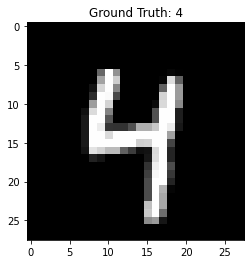

In [27]:
# lets grab something from the test set
import random
total_images = test_data_length # 10000
index = random.randint(0, total_images)
print("Random Test Image:", index)
count = 0
batch = index // test_kwargs["batch_size"]
batch_index = index % int(total_images / len(test_loader))
for tensor_ptr in test_loader:
    data, target = tensor_ptr[0], tensor_ptr[1]
    if batch == count:
        break
    count += 1

print(f"Displaying {index} == {batch_index} in Batch: {batch}/{len(test_loader)}")
if batch_index > len(data):
    batch_index = 0
image_1 = data[batch_index].reshape((28, 28))
label_1 = target[batch_index]
draw_image_and_label(image_1, label_1)

In [28]:
# classify remote
class_num, preds = classify_remote(image_1, model)
print(f"Prediction: {class_num} Ground Truth: {label_1}")
print(preds)

Prediction: 4 Ground Truth: 4
tensor([0.0126, 0.0165, 0.2732, 0.0066, 0.5232, 0.0055, 0.0174, 0.0715, 0.0263,
        0.0471], grad_fn=<SqueezeBackward0>)


In [29]:
local_model = model.get(
    request_block=True,
    reason="To run test and inference locally",
    timeout_secs=5,
)

In [30]:
# classify local
class_num, preds = classify_local(image_1, local_model)
print(f"Prediction: {class_num} Ground Truth: {label_1}")
print(preds)

Prediction: 4 Ground Truth: 4
tensor([0.0102, 0.0124, 0.1134, 0.0108, 0.5166, 0.0939, 0.0339, 0.0314, 0.0334,
        0.1440], grad_fn=<SqueezeBackward0>)


In [31]:
# We can also download an image from the web and run inference on that
from PIL import Image, ImageEnhance
import PIL.ImageOps    

import os
def classify_url_image(image_url):
    filename = os.path.basename(image_url)
    os.system(f'curl -O {image_url}')
    im = Image.open(filename)
    im = PIL.ImageOps.invert(im)
#     im = im.resize((28,28), Image.ANTIALIAS)
    im = im.convert('LA')
    enhancer = ImageEnhance.Brightness(im)
    im = enhancer.enhance(3)


    print(im.size)
    fig = plt.figure()
    plt.tight_layout()
    plt.imshow(im, cmap="gray", interpolation="none")
    
    # classify local
    class_num, preds = classify_local(image_1, local_model)
    print(f"Prediction: {class_num}")
    print(preds)

(89, 93)
Prediction: 4
tensor([0.0706, 0.0215, 0.0486, 0.0395, 0.3014, 0.0405, 0.0926, 0.2044, 0.0720,
        0.1088], grad_fn=<SqueezeBackward0>)


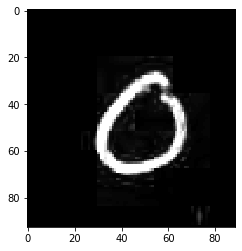

In [33]:
image_url = "https://raw.githubusercontent.com/kensanata/numbers/master/0018_CHXX/0/number-100.png"
classify_url_image(image_url)